<a href="https://colab.research.google.com/github/amradadic/SoftwareProject-SarcasamDetection/blob/SPIRS/SP_BERT_With_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!%%cache
!pip install rpy2

/bin/bash: line 0: fg: no job control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!%%cache
from google.colab import drive

drive.mount('/content/drive')

/bin/bash: line 0: fg: no job control
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data preprocessing

In [4]:
import pandas as pd

x_train = pd.read_csv('drive/MyDrive/SP/Data/x_train.csv') #when not on colab change path to 'split/x_train.csv'
y_train = pd.read_csv('drive/MyDrive/SP/Data/y_train.csv') #'split/y_train.csv'

x_test = pd.read_csv('drive/MyDrive/SP/Data/x_test.csv') #'split/x_test.csv'
y_test = pd.read_csv('drive/MyDrive/SP/Data/y_test.csv') #'split/y_test.csv'

x_val = pd.read_csv('drive/MyDrive/SP/Data/x_val.csv') #'split/x_val.csv'
y_val = pd.read_csv('drive/MyDrive/SP/Data/y_val.csv') #'split/y_val.csv'

df_train = pd.concat([x_train, y_train], axis=1, join='inner')
df_test = pd.concat([x_test, y_test], axis=1, join='inner')
df_val = pd.concat([x_val, y_val], axis=1, join='inner')

df_train.shape, df_val.shape, df_test.shape



((16308, 17), (2878, 17), (4797, 17))

In [5]:
def modify_df_context(df):
  df = df.dropna(subset = ['sar_text','obl_text','eli_text'])
  df = df.reset_index(drop=True)
  #add user_id
  cols = ['sar_text', 'obl_text', 'eli_text']
  df['sar_text'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
  cols = ['obl_text', 'eli_text', 'cue_text', 'obl_id',	'eli_id',	'perspective', 'cue_user', 'obl_user',	'eli_user', 'idx',	'pattern',	'person',	'cue_id', 'sar_user']
  df.drop(cols, axis = 1, inplace = True)
  return df

In [6]:
df_train = modify_df_context(df_train)
df_test = modify_df_context(df_test)
df_val = modify_df_context(df_val)
df_val.head()

,sar_id,sar_text,label
0,1.195560e+18,mean mark lee dreamie_don't think it's kind or...,0
1,1.191391e+18,legit saw yesterday couldnt stop thinking thou...,1
2,1.194126e+18,thats cinema sir lol_oh yeah. forgot. apologie...,1
3,1.195456e+18,released statement referenceshe responsible mi...,0
4,1.189501e+18,obama cancelled:pouting_face::pouting_face::pr...,1


In [7]:
df_train.shape, df_val.shape, df_test.shape

((4445, 3), (772, 3), (1259, 3))

##**Setup & Config**

In [8]:
!%%cache
!pip install -q -U watermark

/bin/bash: line 0: fg: no job control


In [9]:
!%%cache
!pip install -qq transformers

/bin/bash: line 0: fg: no job control


In [10]:
!%%cache
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

/bin/bash: line 0: fg: no job control
Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.20.1



In [11]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Finding max length

In [14]:
token_lens = []

for txt in df_train.sar_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
element_count = len([item for item in token_lens if item > 256])
element_count

7

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


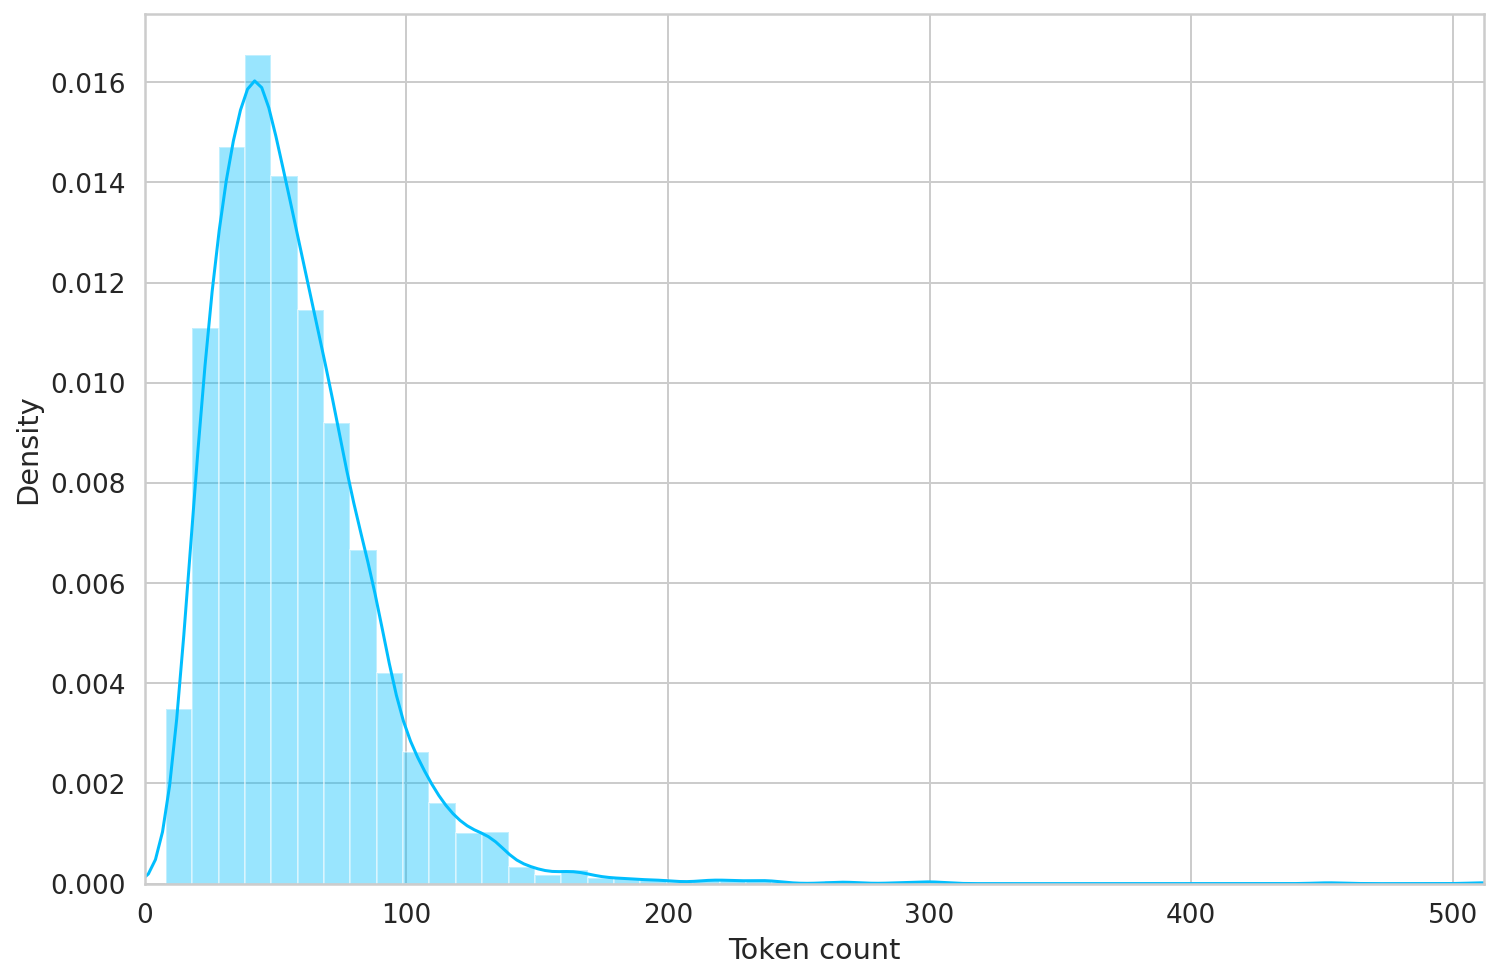

In [16]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [17]:
MAX_LEN = 256

##**Data Loader**

In [18]:
class SarcasticTweetsDataset(Dataset):

  def __init__(self, sar_texts, targets, tokenizer, max_len):
    self.sar_texts = sar_texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sar_texts)
  
  def __getitem__(self, item):
    sar_text = str(self.sar_texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sar_text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'sar_text': sar_text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [19]:
df_train.shape, df_val.shape, df_test.shape

((4445, 3), (772, 3), (1259, 3))

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SarcasticTweetsDataset(
    sar_texts=df.sar_text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['sar_text', 'input_ids', 'attention_mask', 'targets'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## **Classifier**

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

In [25]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    ob = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(ob.pooler_output)
    return self.out(output)

In [26]:
class_names = ['positive', 'negative']

In [27]:
model = SarcasmClassifier(len(class_names))
model = model.to(device)

In [28]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [29]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5095, 0.4905],
        [0.5094, 0.4906],
        [0.5089, 0.4911],
        [0.4987, 0.5013],
        [0.4923, 0.5077],
        [0.5117, 0.4883],
        [0.5221, 0.4779],
        [0.5293, 0.4707],
        [0.4948, 0.5052],
        [0.5301, 0.4699],
        [0.4966, 0.5034],
        [0.5014, 0.4986],
        [0.5055, 0.4945],
        [0.4993, 0.5007],
        [0.4874, 0.5126],
        [0.4969, 0.5031]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## **Training**

In [30]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.5852457506836747 accuracy 0.705511811023622


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5491632052830288 accuracy 0.7344559585492229

Epoch 2/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4771024492575968 accuracy 0.786726659167604


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5554502290122363 accuracy 0.7331606217616581

CPU times: user 1min 9s, sys: 1.35 s, total: 1min 11s
Wall time: 1min 18s


In [34]:
tmp = history['train_acc']

## **Evaluation**

In [37]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.7259729944400317

In [38]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sar_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sar_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sar_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sar_texts, predictions, prediction_probs, real_values

In [39]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [40]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.72      0.44      0.54       468
    negative       0.73      0.90      0.80       791

    accuracy                           0.73      1259
   macro avg       0.72      0.67      0.67      1259
weighted avg       0.72      0.73      0.71      1259



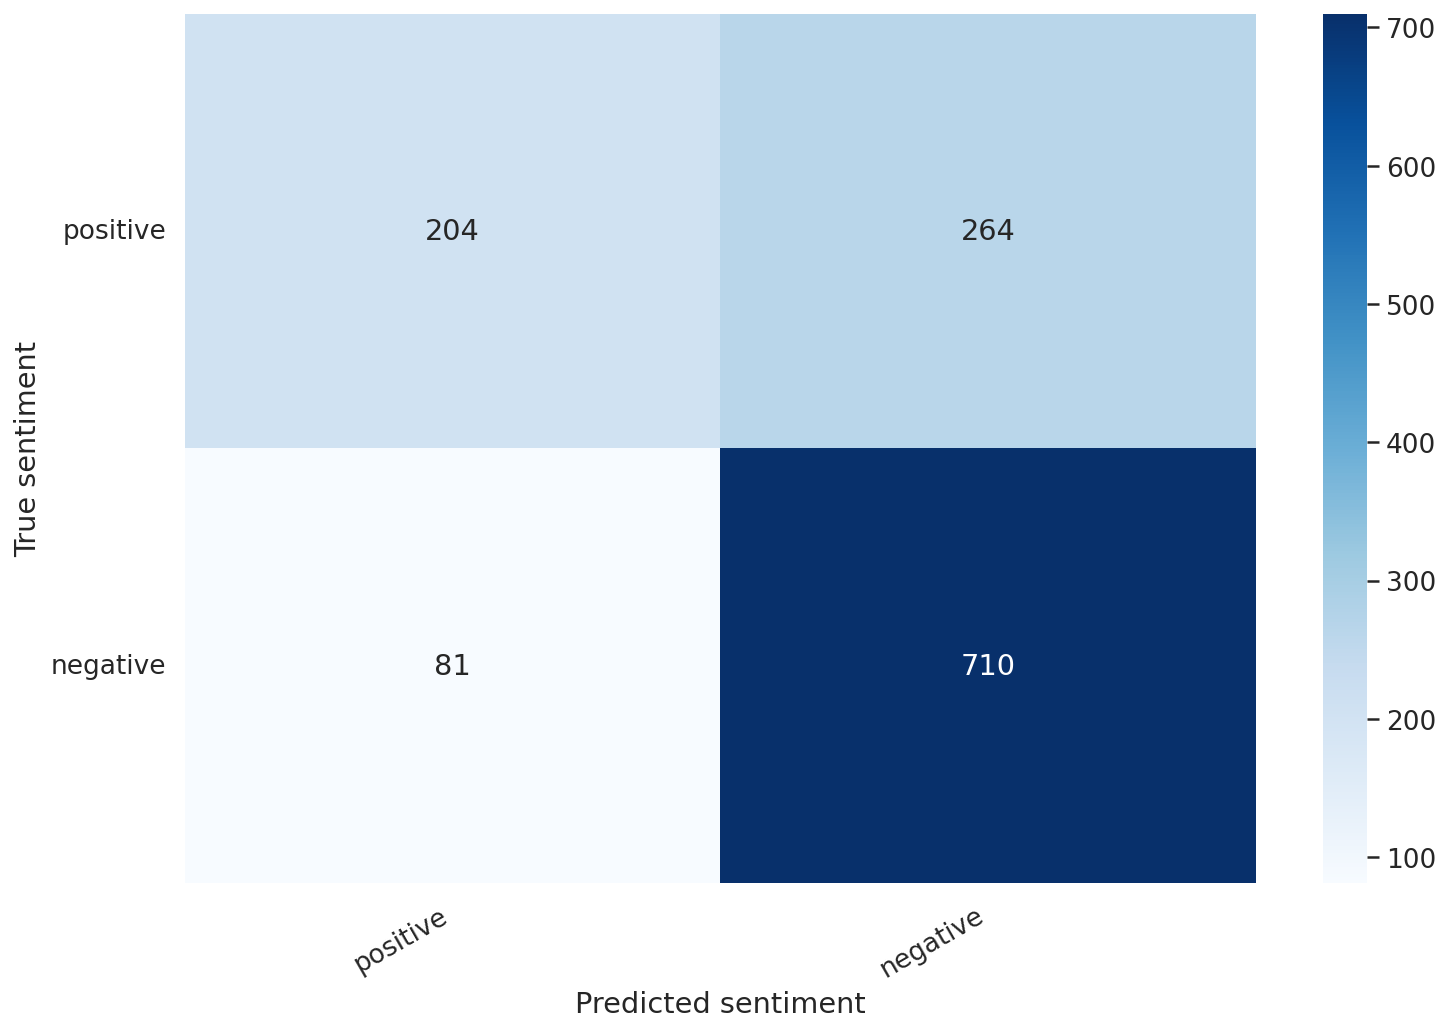

In [41]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## **Saving json file and model**

In [43]:
from metrics import metrics, json_metrics #when not in colab from utils import metrics

sar_ids = df_test['sar_id']
metrics = metrics(y_test, y_pred, ['1','0'])
df= pd.DataFrame({'sar_id': sar_ids, 'label': y_test, 'prediction': y_pred})
json_metrics("/content/drive/MyDrive/SP/JSON/bert_context.json", "sentence BERT", "None",metrics, df)

In [44]:
torch.save(model, 'drive/MyDrive/SP/Models/Bert_Model_Context')